In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import *

In [2]:
import sys
import os
import math
import numpy as np
import pandas as pd
 
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline

import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
 

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import * 
from PIL import Image, ImageEnhance
 
print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.9.2.


In [3]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/gdrive', force_remount=True)
drive_path = '/gdrive/MyDrive/NN/Brain_tumour'
local_path = '/content'

Mounted at /gdrive


In [4]:
!cp '{drive_path}' .a

cp: -r not specified; omitting directory '/gdrive/MyDrive/NN/Brain_tumour'


In [5]:
print({drive_path})
print("OS Version & Details: ")
!lsb_release -a

{'/gdrive/MyDrive/NN/Brain_tumour'}
OS Version & Details: 
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.6 LTS
Release:	18.04
Codename:	bionic


In [6]:
gpu_device_location = tpu_device_location = cpu_device_location = None
print(os.environ)

environ({'NV_LIBCUBLAS_DEV_VERSION': '11.4.1.1043-1', 'NV_CUDA_COMPAT_PACKAGE': 'cuda-compat-11-2', '__EGL_VENDOR_LIBRARY_DIRS': '/usr/lib64-nvidia:/usr/share/glvnd/egl_vendor.d/', 'NV_CUDNN_PACKAGE_DEV': 'libcudnn8-dev=8.1.1.33-1+cuda11.2', 'LD_LIBRARY_PATH': '/usr/lib64-nvidia', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.8.4-1+cuda11.2', 'TCLLIBPATH': '/usr/share/tcltk/tcllib1.19', 'CLOUDSDK_PYTHON': 'python3', 'LANG': 'en_US.UTF-8', 'NV_LIBNPP_DEV_PACKAGE': 'libnpp-dev-11-2=11.3.2.152-1', 'HOSTNAME': 'f4d5a0d56602', 'OLDPWD': '/', 'CLOUDSDK_CONFIG': '/content/.config', 'KMP_EXTRA_ARGS': '--listen_host=172.28.0.12 --target_host=172.28.0.12 --tunnel_background_save_url=https://colab.research.google.com/tun/m/cc48301118ce562b961b3c22d803539adc1e0c19/gpu-t4-s-2yeeeja01kbd0 --tunnel_background_save_delay=10s --tunnel_periodic_background_save_frequency=30m0s --enable_output_coalescing=true --output_coalescing_required=true', 'NV_LIBNPP_VERSION': '11.3.2.152-1', 'NV_NVPROF_DEV_PACKAGE': 'cud

In [7]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2311a469-d0ad-cbb4-43e4-3b7d9e824e8f)


In [8]:
%%bash
RED_COLOR='\033[0;31m'
NO_COLOR='\033[0m'
pkg_name=tree
dpkg -s $pkg_name &> /dev/null
if [ "$?" -ne "0" ] 
    then
        echo "Installing tree utility..."
        apt-get autoclean
        apt-get autoremove
        apt-get install $pkg_name
        if [ "$?" -eq "0" ]
            then
                echo -e ${RED_COLOR}"tree utility installed sucessfully.\n"${NO_COLOR}
        fi
    else
        echo "tree utility is already installed."
fi
tree --version

Installing tree utility...
Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
The following packages will be REMOVED:
  libnvidia-common-460
0 upgraded, 0 newly installed, 1 to remove and 20 not upgraded.
After this operation, 35.8 kB disk space will be freed.
(Reading database ... 124013 files and directories currently installed.)
Removing libnvidia-common-460 (460.106.00-0ubuntu1) ...
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (176 kB/s)
Selecting previously unselected package tree.
(Reading database ... 124008

In [9]:
!tree -d '/gdrive/MyDrive/NN/Brain_tumour'

/gdrive/MyDrive/NN/Brain_tumour
├── Brain-Tumor-Images-Mat-Files
├── Testing
│   ├── No
│   └── Yes
├── Training
│   ├── glioma
│   ├── meningioma
│   ├── no_tumor
│   └── pituitary_tumor
└── Tumor-Mask
    ├── glioma
    ├── meningioma
    └── pituitary_tumor

13 directories


In [10]:
!tree -d "/gdrive/MyDrive/NN/Brain_tumour"

/gdrive/MyDrive/NN/Brain_tumour
├── Brain-Tumor-Images-Mat-Files
├── Testing
│   ├── No
│   └── Yes
├── Training
│   ├── glioma
│   ├── meningioma
│   ├── no_tumor
│   └── pituitary_tumor
└── Tumor-Mask
    ├── glioma
    ├── meningioma
    └── pituitary_tumor

13 directories


In [11]:
#Data Directories setup.
ROOT_DIR = r"/gdrive/MyDrive/NN/"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Brain_tumour")
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
MASK_DIR = os.path.join(DATA_ROOT_DIR, 'Tumor-Mask')

#Tumor classes 
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor', 'no_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]
MASK_DATA_PATHS = [os.path.join(MASK_DIR, tumor_name) for tumor_name in TUMOR_CLASS[:-1]]

In [12]:
#Ensuring all paths exists
assert os.path.isdir(ROOT_DIR) 
assert os.path.isdir(DATA_ROOT_DIR) 
assert os.path.isdir(TRAIN_DIR) 
assert os.path.isdir(MASK_DIR)

In [13]:
image_data_paths = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))

In [14]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

,image_filepaths,tumor_class
0,/gdrive/MyDrive/NN/Brain_tumour/Training/menin...,meningioma
1,/gdrive/MyDrive/NN/Brain_tumour/Training/menin...,meningioma
2,/gdrive/MyDrive/NN/Brain_tumour/Training/pitui...,pituitary_tumor
3,/gdrive/MyDrive/NN/Brain_tumour/Training/pitui...,pituitary_tumor
4,/gdrive/MyDrive/NN/Brain_tumour/Training/pitui...,pituitary_tumor



5.2 Visualisation of Brain MRI Dataset

Dataset Source: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427

Source Code for Conversion of .mat file to .jpg: Google Colab Notebook Link

Final Dataset Link: https://drive.google.com/drive/folders/11QIC82FBdAyq0PUwLVNd22i-oq6lcat1?usp=sharing


In [15]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df, 
                                                      train_size = 0.70, 
                                                      random_state = 42, 
                                                      stratify = image_data_paths_df.tumor_class)
 
train_data, validation_data = train_test_split(intermediate_train_data, 
                                               train_size = 0.80, 
                                               random_state = 42, 
                                               stratify = intermediate_train_data.tumor_class)

In [16]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15, 
                            width_shift_range = 0.1, 
                            zoom_range = 0.01, 
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [17]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [18]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data, 
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data, 
                                                                  x_col = 'image_filepaths', 
                                                                  y_col = 'tumor_class', 
                                                                  seed = 42,
                                                                  batch_size = batch_size, 
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data, 
                                                      x_col = 'image_filepaths', 
                                                      y_col = 'tumor_class', 
                                                      seed = 42, 
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 1936 validated image filenames belonging to 4 classes.
Found 485 validated image filenames belonging to 4 classes.
Found 1038 validated image filenames belonging to 4 classes.


In [19]:
ROOT_CHECKPOINT_DIR_PATH = os.path.join(ROOT_DIR, "Model-Checkpoints")
MLP_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "Multi-Layer-Perceptron")
ALEXNET_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "AlexNet-CNN")
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")

print(ROOT_CHECKPOINT_DIR_PATH)
print(MLP_CHECKPOINT_DIR_PATH)
print(ALEXNET_CHECKPOINT_DIR_PATH)
print(INCEPTIONV3_CHECKPOINT_DIR_PATH)

os.path.isdir(ROOT_CHECKPOINT_DIR_PATH)
os.path.isdir(MLP_CHECKPOINT_DIR_PATH)  
os.path.isdir(ALEXNET_CHECKPOINT_DIR_PATH) 
os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH)

/gdrive/MyDrive/NN/Model-Checkpoints
/gdrive/MyDrive/NN/Model-Checkpoints/Multi-Layer-Perceptron
/gdrive/MyDrive/NN/Model-Checkpoints/AlexNet-CNN
/gdrive/MyDrive/NN/Model-Checkpoints/InceptionV3


True

In [20]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [21]:
alexnet_cp_callback = ModelCheckpoint(ALEXNET_CHECKPOINT_DIR_PATH, 
                                      monitor = 'val_accuracy', 
                                      verbose = 1, 
                                      save_weights_only = True, 
                                      save_freq = 'epoch')


In [22]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()
    

def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize = (8, 6))
    class_names = ['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary\nTumor']
    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), fmt="d", annot = True, cmap = plt.cm.Reds, ax = axis)
    axis.set_title(plot_kwargs['plot_title'], fontsize = 10)
    axis.tick_params(which = 'major', labelsize = 8)
    axis.set_xlabel("Pedicted Class", fontsize = 8)
    axis.set_ylabel("Actual Class", fontsize = 8)
    axis.set_xticklabels(class_names, fontdict = dict(fontsize = 10))
    axis.set_yticklabels(class_names, fontdict = dict(fontsize = 10))
    fig.tight_layout()
    sns.despine()
    
    
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [mean_absolute_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds, squared = False), curr_model_loss, curr_model_accuracy, f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

In [23]:
inceptionv3_cp_callback = ModelCheckpoint(INCEPTIONV3_CHECKPOINT_DIR_PATH, 
                                          monitor = 'val_accuracy', 
                                          verbose = 1, 
                                          save_weights_only = True, 
                                          save_freq = 'epoch')

Experiment 2 - Inception model

In [24]:
inception_v3_model = InceptionV3(include_top = False, 
                                 input_shape = (image_size, image_size, 3), 
                                 pooling = 'avg')
inception_v3_model.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [25]:
inception_cnn_model = Sequential()
inception_cnn_model.add(inception_v3_model)
inception_cnn_model.add(Flatten())
inception_cnn_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
inception_cnn_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
inception_cnn_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
inception_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 1024)              2098176   
                                                                 
 Output-Layer (Dense)        (None, 4)                 4100      
                                                                 
Total params: 23,905,060
Trainable params: 2,102,276
Non-trainable params: 21,802,784
_________________________________________________________________


In [26]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    inception_model_train_history = inception_cnn_model.fit(train_dataset, 
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset, 
                                                            epochs = 60, 
                                                            callbacks = [early_stopping, inceptionv3_cp_callback])

Epoch 1/60
61/61 [==============================] - ETA: 0s - loss: 2.2691 - accuracy: 0.5770
Epoch 1: saving model to /gdrive/MyDrive/NN/Model-Checkpoints/InceptionV3
61/61 [==============================] - 681s 11s/step - loss: 2.2691 - accuracy: 0.5770 - val_loss: 0.6979 - val_accuracy: 0.6990
Epoch 2/60
61/61 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.7485
Epoch 2: saving model to /gdrive/MyDrive/NN/Model-Checkpoints/InceptionV3
61/61 [==============================] - 86s 1s/step - loss: 0.6337 - accuracy: 0.7485 - val_loss: 0.8316 - val_accuracy: 0.6619
Epoch 3/60
61/61 [==============================] - ETA: 0s - loss: 0.5953 - accuracy: 0.7660
Epoch 3: saving model to /gdrive/MyDrive/NN/Model-Checkpoints/InceptionV3
61/61 [==============================] - 85s 1s/step - loss: 0.5953 - accuracy: 0.7660 - val_loss: 0.7849 - val_accuracy: 0.6742
Epoch 4/60
61/61 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.7924
Epoch 4: savi

In [27]:
inception_cnn_model.save("/gdrive/MyDrive/NN/Model-Checkpoints/InceptionV3/InceptionV3_1.h5")
print("Saved model to disk")

Saved model to disk


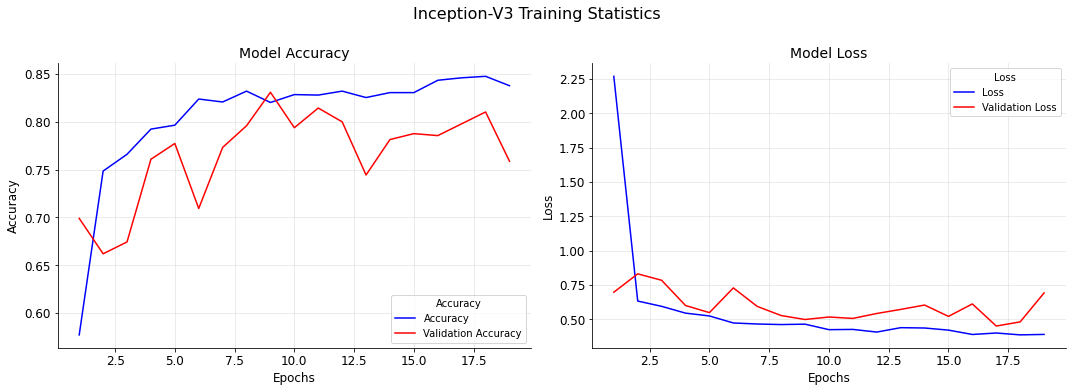

In [28]:
training_process_viz(pd.DataFrame(inception_model_train_history.history), 
                     plot_title = 'Inception-V3 Training Statistics')

33/33 [==============================] - 282s 9s/step


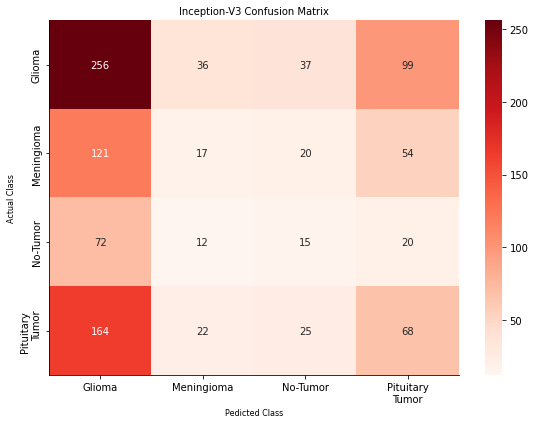

In [29]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    confusion_matrix_viz(inception_cnn_model, 
                         test_dataset, 
                         plot_title = "Inception-V3 Confusion Matrix")


In [30]:
inceptionv3_report_df = generate_report(inception_cnn_model, test_dataset = test_dataset, row_indexes = ['InceptionV3'])
inceptionv3_report_df

33/33 [==============================] - 36s 1s/step


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
InceptionV3,1.368015,3.26975,1.808245,0.695524,0.762042,0.327553


In [31]:
#final_report_df = pd.concat([inceptionv3_report_df, alexnet_report_df, inceptionv3_report_df])
#final_report_df

Fusing Explainability

In [32]:
from skimage import io
from tensorflow.keras.preprocessing import image
from skimage.io import imread
from skimage import transform

from PIL import Image
import numpy as np

url = '/gdrive/MyDrive/NN/Brain_tumour/Testing/test1.jpg'

def read_and_transform_img(url):

    #img = skimage.io.imread(url)
    img =  imread(url, as_gray=False, plugin=None) 
    img = transform.resize(img, (128,128))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img
images = read_and_transform_img(url)

float32
(1, 128, 128, 3)
4


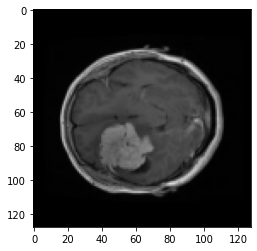

In [33]:
from matplotlib import image
from matplotlib import pyplot

plt.imshow(np.squeeze(images)) 

# summarize shape of the pixel array
print(images.dtype)
print(images.shape)
print(images.ndim)

pyplot.show()

Fusing XAI

In [34]:
!pip install lime
import lime
from lime import lime_base
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime import lime_image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=34a060436c23456fbe8346f47fad0d7811b41ec014e967fe31dfcdade05d722f
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [35]:
KERNEL_WIDTH = 1.75
FEATURE_SELECTION= 'lasso_path'
explainer = lime_image.LimeImageExplainer(kernel_width=KERNEL_WIDTH, feature_selection=FEATURE_SELECTION, verbose=True)

In [36]:
explanation = explainer.explain_instance(images[0].astype('double'), inception_cnn_model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
explanation1 = explainer.explain_instance(images[0].astype('double'), inception_cnn_model.predict,  
                                         top_labels=3, hide_color=0, num_samples=5000)
explanation2 = explainer.explain_instance(images[0].astype('double'), inception_cnn_model.predict,  
                                         top_labels=3, hide_color=0, num_samples=8000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step
Intercept 0.022159874208953267
Prediction_local [0.15758275]
Right: 0.115603074
Intercept 0.15212609714279204
Prediction_local [0.45410611]
Right: 0.2960253
Intercept 0.3871404296272589
Prediction_local [0.55059349]
Right: 0.58820564


  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
Intercept 0.022406335494966248
Prediction_local [0.15351376]
Right: 0.115603074
Intercept 0.13039674778001023
Prediction_local [0.46981328]
Right: 0.2960253
Intercept 0.3935219595484921
Prediction_local [0.55477675]
Right: 0.58820564


  0%|          | 0/8000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
Intercept 0.022486695845837956
Prediction_local [0.15683558]
Right: 0.115603074
Intercept 0.13292825892729723
Prediction_local [0.46017725]
Right: 0.2960253
Intercept 0.398327764598623
Prediction_local [0.55361236]
Right: 0.58820564


(-0.5, 127.5, 127.5, -0.5)

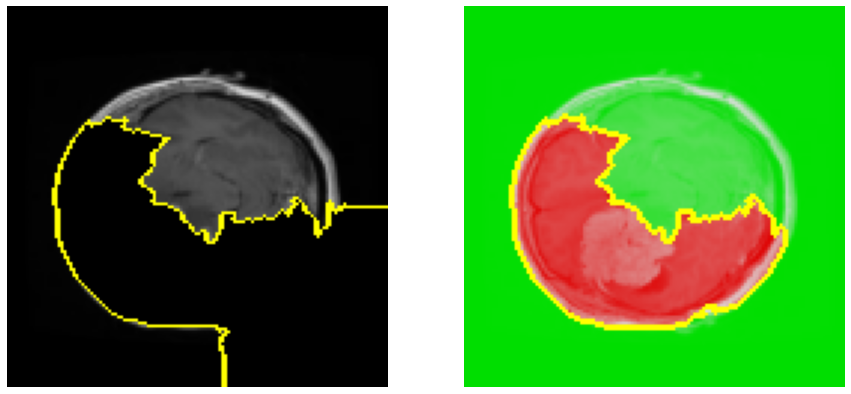

In [37]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')